# Asymmetric Cryptography Schemes, Signatures, and Forgeries in RSA and Diffie-Hellman Key Exchanges

By Ivan von Greiff

This project will investigate the theory behind two popular Asymmetric Cryptography techniques, and implement the theory into programs using SageMath (a popular library to use when dealing with algebraic structures, coding, and cryptography). These two asymmetric techniques are cryptographically secure thanks to their dependence on two different types of problems which are difficult to solve for a malicious third party with access to the cipher text. First we will investigate the Diffie-Hellman key exchange system which is based on the "discrete logarithm problem," and then we will investigate the RSA key exchange system which is based on the "factoring of large numbers problem." I will explain the these problems in greater detail in the coming sections.

Within my program, I include notes for important concepts to help understand the significance behind the code, as well as mistakes I made when implementing the theory into SageMath.

The contents of my project are as follows:

1. DH Key Generation
2. DH Private Key Creation
3. DH Key Exchange and Testing
4. RSA Key Generation
5. RSA Encoding and Decoding
6. RSA Signatures and Third Party Verification
7. RSA Forgery Capabilities


# Task 1: Diffie-Hellman Key Exchange

The cryptographic security of the Diffie Hellman key exchange system is based on the discrete logarithm problem. Essentially, any malicious party with access to the ciphertexts shared between the communicating parties must be able to solve the "discrete logarithm problem" in order to convert the ciphertext into the original message. 

The challenge of the discrete logarithm problem lies in finding the exponent $x$ in the expression $\alpha^x \text{ mod } p$ given $\alpha$ (the base) and $\alpha^x \text{ mod } p$ (the result). It becomes intractable in a reasonable amount of time as the size of $p$ and $x$ increases. This intractability comes from the fact that we are working within a special type of domain i.e. a finite field, rather than e.g. $\mathbb{R}$ where the problem could easily be solved. Since the domain of operation is full of discrete numbers, this relegates the problem to attempting many different values until a solution is found, hence the intractability.

In this task, we want to communicate securely with our friend Bob using a hybrid encryption scheme. To do so, we first establish a shared session key using the Diffie-Hellman key exchange protocol as described in the lecture:

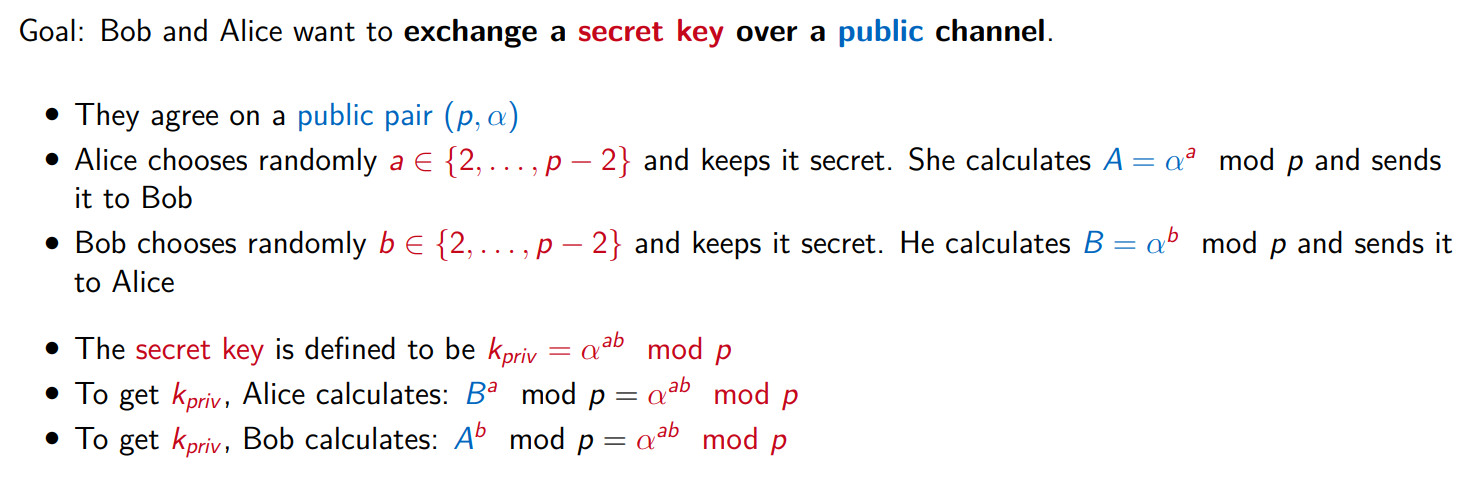

## Key generation

We first implement the function keygen, which chooses a finite field $F_p$ for the key exchange, a generator $g$ of $F_p$ and our private/public keypair. 

Input: 
- An integer $s$, the bit length of the prime $p$ defining $F_p$.

Output: 
- A prime $p$
- A generator $g$ of the finite Field $F_p$
- Our secret exponent $sk$
- Our public message $pk$  which will be broadcast to Bob.

In [1]:
def keygen(s):

    p  = random_prime(n=2**s, lbound=2**(s-1)) # random prime of s bits : args(upper bound, lower bound)
    F  = GF(p) # finite field of cardinality p
    g  = F.primitive_element() # generator of multiplicative group (g raised to all powers will generate the finite field)
    sk = F(randint(2, p-2)) # we want to choose a random element from our finite field restricted between 2 and p-2
    pk = F(g**sk) # raise the primitive element to the power of the randomly chosen element from our finite field (restricted from 2 to p-2) and modulo p
    
    return p, g, sk, pk

# SANITY CHECKS (comment out)
s=4
rpn = random_prime(n=2**s, lbound=2**(s-1))
print(rpn)
print(bin(rpn)[2:])
print(GF(rpn))
finite_field = GF(rpn)
print(finite_field.primitive_element())
print(finite_field(randint(2,rpn-2)))
print(finite_field(rpn+2))

11
1011
Finite Field of size 11
2
8
2


## Generating the session key

Next, we want to compute the shared session key by reading Bob's public key.

Input:
- A prime p defining $F_p$
- Bob's public message $pk\_bob$
- our own secret exponent $sk$

Output:
- the shared session key $session\_key$

In [2]:
def shared_secret(p, pk_bob, sk):

    # your code here
    F = GF(p) 
    # We take Bob's public message, and raise it to the power of our own secret exponent, modulo it by p, and this is the private key
    session_key = F(pk_bob**sk) 
    
    return session_key

## Testing the implementation

Run the three cells with the code above and then run this cell to test the implementation.

In [3]:
### S A N I T Y   C H E C K ###

t_p, t_g, t_sk, t_pk = keygen(8)
assert is_prime(t_p), "keygen returned a p that is not prime"
t_F = GF(t_p)
assert t_F(t_g).multiplicative_order() == t_p - 1, "keygen returned a g that is not a generator of Fp"

print(" --- You publish the public parameters:", GF(t_p), "with generator g =", t_g)
print(" --- Your keypair (sk, pk) is: (", t_sk, ",", t_pk, "), You broadcast your public key", t_pk, "to Bob.")

t_kg = lambda x: [t_g**x, t_pk**x]
t_pk_bob, t_session_key_bob = t_kg(t_F.random_element())

print("Bob broadcasts his public key", t_pk_bob) 

t_session_key = shared_secret(t_p, t_pk_bob, t_sk)
print(" --- You compute the shared session key:", t_session_key)
print("Bob computes the shared session key", t_session_key_bob) 

assert t_session_key == t_session_key_bob, "You and Bob got different session keys"

 --- You publish the public parameters: Finite Field of size 227 with generator g = 2
 --- Your keypair (sk, pk) is: ( 62 , 26 ), You broadcast your public key 26 to Bob.
Bob broadcasts his public key 122
 --- You compute the shared session key: 21
Bob computes the shared session key 21


## Key Points
**Key Point 1)** In this implementation, we generate the secret exponent sk such that $sk < p-1$. Why do we not allow $sk = p-1$?

$\rightarrow$ Given that we are working within a Finite Field, and the public key which we are using is defined to be a primitive element of the finite field (i.e. $\alpha$ raised to all powers generates all elements of the field), then according to Fermat's Little Theorem, we know that $\alpha^{p-1} \coloneqq 1 \,\, \text{mod} \,\, p$. As a result, during the key exchange, Alice or Bob would simply be exchanging the value of $1$ with each other, rendering the private key computation for e.g. Bob to be simply $B^{ab} \,\, \text{mod}  \,\, p = 1^b \,\, \text{mod} \,\, p = 1$. If this were allowed by the Diffie Hellman key exchange, then any eavesdropper would simply attempt using this trivial value before attempting any brute-force decryption method. 

**Key Point 2)** Assume that the eavesdropper cannot only read exchanged messages, but also manipulate them. Is a Diffie-Hellman key exchange still secure?

$\rightarrow$ If the eavesdropper can manipulate the exchanged message, then he or she has the ability to modify e.g. Alice's $B^a \,\, \text{mod}  \,\, p$ before Bob gets access to it, meaning he would be attempting to compute $f(B^a \,\, \text{mod}  \,\, p)^b$ instead of $B^{ab} \,\, \text{mod}  \,\, p$, where $f$ is some arbitrary function. Therefore his computation to calculate the private key would be corrupted, and ruin the key exchange. 

# Task 2: RSA PKE Scheme

The cryptographic security of the RSA key exchange system is based on the "factoring of large integers problem," where in order to convert the ciphertext into the original message (without the private key) a malicious third party would have to factor a large number. This problem relies on the fact that while multiplying two large prime numbers $p$ and $q$ together is computationally easy, factoring the result $n=pq$ is intractable in a reasonable amount of time (depending on the size of the number). 

In this task, we will implement the three basic functions of "textbook" RSA: Keygen, Enc, and Dec.

First, we implement the key generation algorithm:

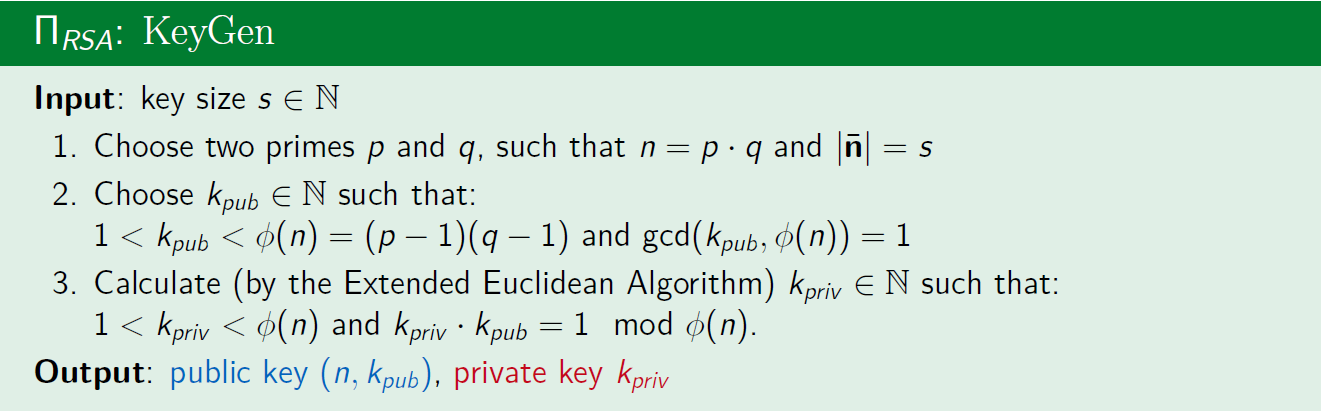

In [13]:
def keygen(s):

    s_half = floor(s/2) # a hint for choosing p,q 

    # step 1: Compute p, q and n such that n = p*q and the bitlength of n is s.
    p = random_prime(2^s_half, False, 2^(s_half-1)) # random prime, p is exactly 's_half' bits long
    q = random_prime(2^(s-s_half), False, 2^(s-s_half-1)) # random prime, q is exactly 's-s_half' bits long
    n = p*q # Multiplying p which is 's_half' bits long with q which is 's-s_half' bits long yields a number which is 's-s_half+s_half' = 's' bits long
    
    # uncomment to assure correct bitwidth
    while int((log(n) / log(2)) + 1) != s:
        p = random_prime(2^s_half, False, 2^(s_half-1)) # random prime, modify
        q = random_prime(2^(s-s_half), False, 2^(s-s_half-1)) # random prime, modify

        n = p*q 
    
        
    #step 2: choose the public key in [2, phi(n)) such that gcd(k_pub, phi(n)) = 1 
    phi   = (p-1)*(q-1) # modify
    k_pub = randint(2, phi-1) # randomized choice of public key restricted within this interval

    while gcd(k_pub, phi) != 1: # check if k_pub valid choice i.e. greatest common divisor between both is 1
        k_pub = randint(2, phi-1) # rerandomize choice (until we get gcd = 1)

    #step 3: Calculate the private key such that k_priv is the multiplicative inverse of k_pub with respect to phi(n).
    # The Extended Euclidean Algorithm not only finds the greatest common divisor (GCD) of two integers, 
    # but also finds coefficients x and y such that ax + by = gcd(a,b)
    # Which in our case should be k_pub*x + phi*y = gcd(k_pub, phi) = 1

    # In RSA, Extended Euclidean Algorithm will return the following args:
        # Arg 1: gcd(k_pub, phi) which must = 1 (since we chose k_pub as such!)
        # Arg 2: private key
    dummy_one, k_priv, k_pub_2 = xgcd(k_pub, phi) 

    # SANITY CHECKS
    #print(k_pub_2*phi % phi)   # Must be zero (helps fulfill extended euclidean algorithm equation k_pub*x + phi*y = gcd(k_pub, phi) = 1)
    #print(k_pub*k_priv % phi)  # Defined to be 1!
    #print(k_pub)
    #print(k_pub_2)
    #assert k_pub == k_pub_2, 'the public keys are not the same!'
    
    return n, k_pub, k_priv, phi

In [14]:
### Test cases ######
### S A N I T Y   C H E C K ###

s = 128

t_n, t_k_pub, t_k_priv, t_phi = keygen(s)
print(t_n)
print(t_k_pub)

num_bits = int((log(t_n) / log(2)) + 1)
assert num_bits == s, 'the public parameter n does not have bitlength s'
assert gcd(t_k_pub, t_phi) == 1, 'the public key you computed is not coprime to phi(n).' 

assert t_k_priv*t_k_pub % t_phi == 1, 'the private key is not the multiplicative inverse of the public key modulo phi(n)'

238964292895730815313969285843501916377
224598314273135361692390244920798014723


Next, implement the encryption and decryption of a message which will be an integer in [$1$, $n-1$]

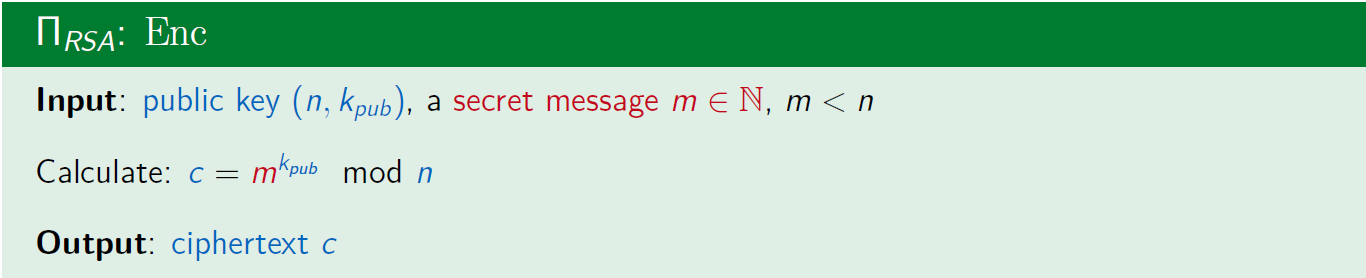
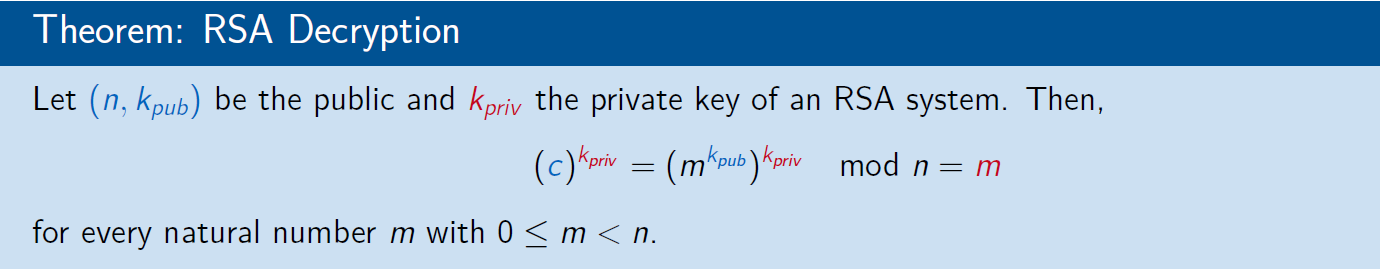

In [15]:
def enc(m, n, k_pub):
    
    # Note! m**k_pub % n is too complex!
    c = power_mod(m, k_pub, n) # ciphertext, take our message and raise it to the power of the public key, and modulo n

    return c

def dec(c, n, k_priv):

    # Note! c**k_priv % n is too complex!
    m_prime = power_mod(c, k_priv, n) # decrypted message, take our ciphertext and raise it to the power of our private key, and modulo n
    
    return m_prime

In [17]:
### Test cases ######
### S A N I T Y   C H E C K ###

t_m = randint(1, t_n-1)
assert dec(enc(t_m, t_n, t_k_pub), t_n, t_k_priv) == t_m, 'encrypting and decrypting a message does not yield the original message'
print('Success')

Success


## Key Points
**Key Point 3)** keygen(s) outputs $\phi(n)$. Should this value be public or private? Explain!

$\rightarrow$ Knowing $\phi(n)$ would allow an attacker to determine the prime factors $p$ and $q$, thus compromising the RSA system. The whole security of this system lies in the attacker being unable to factorize $n=pq$ and use these individual factors to compute $\phi(n)=(p-1)(q-1)$. Were such an attacker able to figure out the value of $(p-1)(q-1)$, then they could simply take our ciphertext, and raise it to the power of every element of the field (modulo $\phi(n)$) in order to quickly find the original message $m$ 

**Key Point 4)** In the key generation, we pick $k_{pub}$ and compute $k_{priv}$. Could one also pick $k_{priv}$ and compute $k_{pub}$? When could this be beneficial?

$\rightarrow$ It is possible, however the public exponent $k_{\text{pub}}$ is typically chosen from a small set of primes (usually to take the specific value of $65537$) which have been shown to exhibit good performance. Its relatively simple binary expression (i.e. small Hamming weight $10000000000000001$) allows for fast exponentiation during encryption and verification with the square-and-multiply algorithm. The modulo $\phi(n)$ and the chosen private key are instead the variables which can take a wide range of values, leaving the public key to be somewhat standardized to allow for more optimized performance.

# Task 3: RSA Signature Scheme

In this task, we play the role of Eve and we eavesdrop a communication between Alice and Bob. Since they know that others may listen and interfere their communication, they use the (textbook) RSA signature scheme

First, we will generate your own RSA private and public key. For this, we will reuse the algorithm you've implemented for the previous task:

In [19]:
s = 64

n, k_pub, k_priv, phi = keygen(s)
assert k_pub * k_priv % phi == 1

Now we will send Bob a signed message and we ask him to verify our signature.

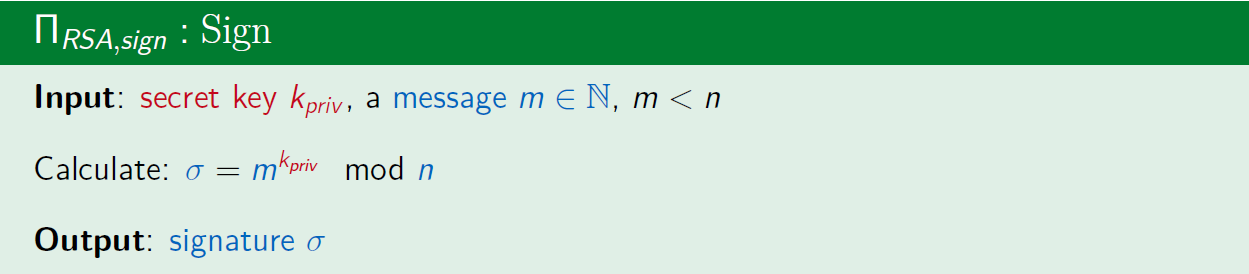

In [20]:
def sign(k_priv, m, n):

    # Signature = message raised to the power of the private key, modulo n
    sigma = power_mod(m, k_priv, n) # Note: m**k_priv % n is too complex!

    return sigma

In [21]:
### Test cases ######
### S A N I T Y   C H E C K ###

m = randint(1, n - 1)
sig = sign(k_priv, m, n)

## verification by Bob ##
m_prime = power_mod(sig, k_pub, n) # The message raised to the powers of both the private and public key should give us back our message again
assert m_prime == m, 'Bob could not verify the signature using your public key'

3


Alice is generating two messages $m_1$ and $m_2$ and sends them to Bob together with her signatures $\sigma_1$ and $\sigma_2$ (using the same public parameter $n$).

1) Verify that Alice is the legitimate signer of the messages using Alice's public key $pk_{A}$\
2) Show that the plain "textbook" version of the RSA signature scheme is insecure by forging a new signature $\sigma_{new}$ for a message $m_{new}$ different from $m_1$ and $m_2$.

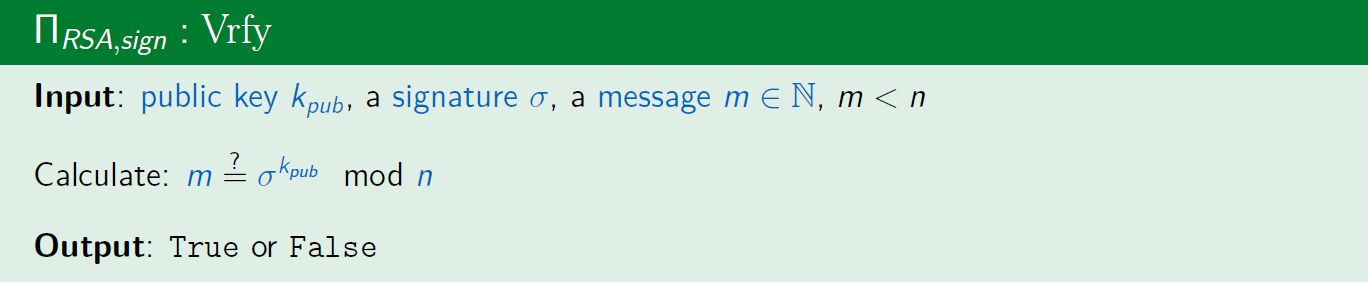

In [26]:
def verify(m, sig, pk_A, n):

    m_decoded = power_mod(sig, pk_A, n) # sig**pk_A % n
    result = (m == m_decoded) # Check if equal
    
    return result

def forge(m1, m2, sig1, sig2, n):

    # your code here    
    m_new   = m1*m2 % n # Thanks to the multiplicative property of RSA, we can multiply two messages to get a new message
    sig_new = sig1*sig2 % n # Thanks to the multiplicative property of RSA, we can multiply two signatures to get a new signature
    # Both without even knowing the private key!
    
    return m_new, sig_new

In [27]:
### S A N I T Y  C H E C K S ######

# test verification
messages = [randint(1, n-1) for i in range(10)]
signatures = [sign(k_priv, messages[i], n) for i in range(10)]
assert all([verify(messages[i], signatures[i], k_pub, n) for i in range(10)]), 'Some valid message-signature pair was rejected by the verification function'
assert not any([verify(messages[i], signatures[i]+1 % n, k_pub, n) for i in range(10)]), 'Some invalid message-signature pair was accepted by the verification function'

# test forgery
t_m1 = randint(1, n-1)
t_m2 = randint(1, n-1)

t_sig1 = sign(k_priv, t_m1, n)
t_sig2 = sign(k_priv, t_m2, n)

f_m, f_s = forge(t_m1, t_m2, t_sig1, t_sig2, n)
assert power_mod(f_s, k_pub, n) == f_m, 'Bob was not convinced by your forged message-signature pair'
print('Bob was convinced by your forgery!')

3
Bob was convinced by your forgery!


## Questions
**Key Point 5)** In practice, one would not sign the message, but a hash of the message. Why is this beneficial? Why is it secure?

$\rightarrow$ It is always more efficient to sign smaller message (i.e. the hash) rather than a larger original message. Also, given a hash value, it is computationally infeasible to find the original input message, which ensures that an attacker cannot derive the original message from the hash. Any change in the message (even a single bit) will result in a completely different hash, ensuring that any alteration to the message can be detected. It is also computationally infeasible to find 2 different messages that produce the same hash. Finally, by signing the hash, you ensure that the message has not been altered, as otherwise the hash would change, making the signature invalid

**Key Point 6)** Which property of RSA allows the forgery? How can this be avoided using padding?

-> The property of RSA that allows for forgery is its multiplicative property. $$\text{RSA}(m_1 \times m_2) = \text{RSA}(m_1) \times \text{RSA}(m_2) \,\, \text{mod} \,\, n$$ This means that if an attacker can produce a valid signature without knowing the original message.

To counteract this, padding can be used to ensure that the messages being signed or encrypted have a specific structure, making it harder to manipulate them in a way that would exploit this intrinsic vulnerability. By introducing randomness via padding, we can ensure that even if the same message is encrypted or signed, the output will be different each time. One commonly used padding scheme is $\text{PKCS\#1 v1.5 Padding}$, where a string of random bytes are added to the message before encryption or signing. The padded message has a specific format, which must be validated during decryption or verification. 

Another padding scheme could be $\text{Optimal Asymmetric Encryption Padding}$, which uses a combination of hash functions and a mask generating function to pad the message. This ensure the final padded message has high entropy, making it difficult for an attacker to guess or manipulate the message.